# 03. LangGraph를 활용한 Agent 구축

https://wikidocs.net/264624

In [43]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [44]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("langgraph_RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
langgraph_RAG


## LangGraph Retrieval Agent
검색 에이전트는 인덱스에서 검색할지 여부에 대한 결정을 내리고 싶을 때 유용합니다.  
검색 에이전트를 구현하기 위해서는 LLM에 검색 도구에 대한 접근 권한을 제공하기만 하면 됩니다. 이를 LangGraph로 구현해 봅시다!   

### Retriever

In [45]:
import json
from langchain.embeddings import CacheBackedEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document
from langchain.storage import LocalFileStore
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_upstage import UpstageEmbeddings

file_dir = "/home/yoojin/ML/aiffel/HackaThon/modu_hackaton/LLM/files/menu_1017.json"

docs = [
    Document(
        page_content=json.dumps(obj["page_content"], ensure_ascii=False),
    )
    for obj in json.load(open(file_dir, "r", encoding="utf-8"))
]

text_splitter = CharacterTextSplitter(separator="\n\n", chunk_size=200, chunk_overlap=0)
split_docs = text_splitter.split_documents(docs)

embeddings = UpstageEmbeddings(model="solar-embedding-1-large")
cache_dir = LocalFileStore(f"./.cache/embeddings/{file_dir.split('/')[-1]}")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings=embeddings,
    document_embedding_cache=cache_dir,
    namespace="solar-embedding-1-large",
)

vectorstore = FAISS.from_documents(split_docs, cached_embedder)

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})


In [46]:
# # Ensemble Retriever 테스트
# query = "매콤한 메뉴는 뭐가있어?"
# results = ensemble_retriever.get_relevant_documents(query)
# for i, doc in enumerate(results):
#     print(f"\n검색 결과 {i+1}:")
#     print(doc.page_content)

In [47]:
from langgraph.prebuilt import ToolNode
from langchain.tools.retriever import create_retriever_tool

# 맥도날드의 메뉴에 대한 정보를 검색하고 반환하는 도구를 생성합니다.
tool = create_retriever_tool(
    retriever,
    "retrieve_menu_data", 
    "Search and return McDonald's menu information.",
)

tools = [tool]

# 도구들을 실행할 ToolNode 객체를 생성합니다.
tool_executor = ToolNode(tools)

In [48]:
# tool.invoke("매콤한 버거")

### Agent state 설정  
그래프를 정의해야 합니다.  

- AgentState 는 각 노드에 전달하는 state 객체입니다.  
- AgentState 는 messages의 리스트로 담깁니다.  
- 그런 다음 그래프의 각 노드는 AgentState 를 추가합니다.  

In [49]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

In [50]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [51]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [52]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [53]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)


In [54]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()


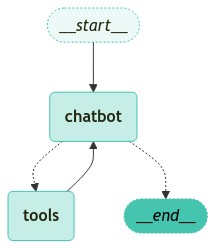

In [55]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


In [56]:
from langchain_teddynote.messages import display_message_tree

question = "매콤한 버거"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])



STEP: chatbot

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_WVpWudMsByyaF5nhwtEAJnpq"
                function: {"arguments": "{"query":"spicy burger"}", "name": "retrieve_menu_data"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 17
            prompt_tokens: 61
            total_tokens: 78
            completion_tokens_details: {"reasoning_tokens": 0, "audio_tokens": 0, "accepted_prediction_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"cached_tokens": 0, "audio_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_0ba0d124f1"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-3a7b4da5-ce6e-47b9-83ff-ce05b6d56448-0"
    example: False
    tool_calls:
        index [0]
            name: "retrieve_menu_data"
            arg